# Training an agent to play Mario

In [ ]:
import torch
from torch import nn
from torchvision import transforms as T
from PIL import Image
import numpy as np
from pathlib import Path
from collections import deque
import random, datetime, os, sys

# A tool kit for RL
import gymnasium as gym
import matplotlib.pyplot as plt

from tensordict import TensorDict
from torchrl.data import TensorDictReplayBuffer, LazyMemmapStorage

# NES Emulator
from nes_py.wrappers import JoypadSpace

# A tool kit for visualization
from JSAnimation.IPython_display import display_animation
from matplotlib import animation

# Add the src directory to the Python path
src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

%matplotlib inline

## Environment

Below shows how we can create an environment with customized action sets.

In [ ]:
import gymnasium as gym
from env import create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with full action space
env = create_env("ALE/MarioBros-v5", full_action_space=True)
state = env.reset()

# Print the observation space and action space
print(f'state: {state}')
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

env.close()

In [ ]:
import gymnasium as gym
from env import SIMPLE_MOVEMENT, create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with simple movement action space
env = create_env("ALE/MarioBros-v5", 
                 action_set=SIMPLE_MOVEMENT, 
                 skip_frames=2, 
                 gray_scale=False, 
                 resize_shape=64,
                 full_action_space=False)
state = env.reset()

# Print the observation space and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

env.close()

In [ ]:
import gymnasium as gym
from env import COMPLEX_MOVEMENT, create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with complex movement action space
env = create_env("ALE/MarioBros-v5", 
                 action_set=COMPLEX_MOVEMENT, 
                 full_action_space=False)
state = env.reset()

# Print the observation space and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

env.close()

In [ ]:
import gymnasium as gym
from env import create_env, __version__

print(f'Using environment version: {__version__}')

# Create environment with default RIGHT_ONLY action space
env = create_env("ALE/MarioBros-v5", full_action_space=False)
state = env.reset()

# Print the observation space and action space
print(f'Observation space: {env.observation_space}')
print(f'Action space: {env.action_space}')

Visualize how the agent play the game by randomly selecting actions.

In [ ]:
from utils import display_frames_as_gif
import numpy as np
import matplotlib.pyplot as plt
from env import create_env

env = create_env("ALE/MarioBros-v5", stack_frames=1, full_action_space=False, gray_scale=True, resize_shape=84)

# Environment reset and frame capture
observation, info = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = []

print(f"Initial observation shape: {observation.shape}")
print(f"Observation type: {type(observation)}")

for step in range(MAX_STEPS):
    # Capture the processed observation
    if isinstance(observation, np.ndarray):
        frame = observation
    elif hasattr(observation, '__array__'):  # LazyFrames from FrameStack
        frame = np.array(observation)
    else:
        frame = np.array(observation)
    
    print(f"Frame shape at step {step}: {frame.shape}")

    # Use the most recent frame if it is a stacked frame
    if len(frame.shape) == 3 and frame.shape[0] == 4:  # Stacked frames
        frame = frame[-1]  # Get the most recent frame
    
    # If the frame is 2D (grayscale), repeat it to create a 3D array for visualization
    if len(frame.shape) == 2:
        frame = np.repeat(frame[:, :, np.newaxis], 3, axis=2)
    
    frames.append(frame)
    
    action = env.action_space.sample()  # replace with your agent's action
    observation, reward, done, trunc, info = env.step(action)
    
    infos.append(info)
    r.append(reward)
    
    if done or trunc:
        break

r = np.array(r)

print(f"\nTotal frames captured: {len(frames)}")
print(f"Shape of first frame in frames list: {frames[0].shape}")

# Display frames as GIF
display_frames_as_gif(frames)

# Plot rewards
plt.figure(figsize=(10, 5))
plt.plot(r)
plt.title('Rewards')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()

print('Sum of rewards is ', r.sum())

# Display a single frame for inspection
plt.figure(figsize=(5, 5))
plt.imshow(frames[0], cmap='gray')
plt.title('First Frame')
plt.axis('off')
plt.show()

Visualize how the agent plays the game by randomly selecting actions. (stacked 4 frames)

In [ ]:
from utils import display_frames_as_gif
import numpy as np
import matplotlib.pyplot as plt
from env import create_env

env = create_env("ALE/MarioBros-v5", stack_frames=4, full_action_space=False, gray_scale=True, resize_shape=84)

# Environment reset and frame capture
observation, info = env.reset()
r = []
infos = []
MAX_STEPS = 500
frames = []

print(f"Initial observation shape: {observation.shape}")
print(f"Observation type: {type(observation)}")

for step in range(MAX_STEPS):
    # Capture the processed observation
    if isinstance(observation, np.ndarray):
        frame = observation
    elif hasattr(observation, '__array__'):  # LazyFrames from FrameStack
        frame = np.array(observation)
    else:
        frame = np.array(observation)
    
    print(f"Frame shape at step {step}: {frame.shape}")

    # Use the most recent frame if it is a stacked frame
    if len(frame.shape) == 3 and frame.shape[0] == 4:  # Stacked frames
        frame = frame[-1]  # Get the most recent frame
    
    # If the frame is 2D (grayscale), repeat it to create a 3D array for visualization
    if len(frame.shape) == 2:
        frame = np.repeat(frame[:, :, np.newaxis], 3, axis=2)
    
    frames.append(frame)
    
    action = env.action_space.sample()  # replace with your agent's action
    observation, reward, done, trunc, info = env.step(action)
    
    infos.append(info)
    r.append(reward)
    
    if done or trunc:
        break

r = np.array(r)

print(f"\nTotal frames captured: {len(frames)}")
print(f"Shape of first frame in frames list: {frames[0].shape}")

# Display frames as GIF
display_frames_as_gif(frames)

# Plot rewards
plt.figure(figsize=(10, 5))
plt.plot(r)
plt.title('Rewards')
plt.xlabel('Steps')
plt.ylabel('Reward')
plt.show()

print('Sum of rewards is ', r.sum())

# Display a single frame for inspection
plt.figure(figsize=(5, 5))
plt.imshow(frames[0], cmap='gray')
plt.title('First Frame')
plt.axis('off')
plt.show()

After applying wrappers to the environment, the state space is reduced to 84x84x4. The agent will use a Dueling Double Deep Q-Network (Dueling DDQN) with Prioritized Experience Replay to learn the Q-values.

## Training

### Environment Setup

We use a custom environment setup for Super Mario Bros, which includes:

- Custom action space (SIMPLE_MOVEMENT)
- Frame skipping (4 frames)
- Grayscale conversion
- Observation resizing (84x84)
- Frame stacking (4 frames)

This preprocessing helps to reduce the input complexity and speed up training.

### Training Setup

The training process is configured with the following hyperparameters:

- **State and Action Dimensions:**
  - `state_dim`: The dimensionality of the state space.
  - `action_dim`: The number of possible actions.

- **Network Configuration:**
  - `network_type`: Specifies the type of Q-network to use, defaulting to "duelling" (which refers to the dueling architecture).
  - `ddqn`: Boolean flag indicating whether to use Double DQN (default: `True`).

- **Exploration Strategy:**
  - `exploration_rate`: Initial exploration rate set to 1.0, encouraging exploration at the start.
  - `exploration_rate_decay`: Decay factor for reducing exploration rate over time.
  - `exploration_rate_min`: Minimum value for exploration rate, preventing it from dropping too low (set to 0.1).

- **Training Parameters:**
  - `gamma`: Discount factor for future rewards (set to 0.9).
  - `optimizer`: Adam optimizer used with a learning rate of 0.00025.
  - `loss_fn`: Huber loss (SmoothL1Loss) is used to calculate the error between predicted and target Q-values.

- **Replay Buffer:**
  - `memory`: A replay buffer with a capacity of 1 million experiences, supporting prioritized replay if enabled.
  - `batch_size`: The size of each training batch (set to 32).

- **Training Schedule:**
  - `burnin`: Minimum number of experiences (10,000) required before starting the training process.
  - `learn_every`: The model updates the Q-network every 3 experiences.
  - `sync_every`: The target network is synchronized with the online network every 10,000 experiences.

- **Noise and Noise Decay:**
  - `noise`: Initial noise factor set to 0.05.
    - `noise_decay`: Noise decays by 0.99 every episode.

- **Model Saving:**
  - `save_every`: The model is saved every 500,000 experiences to ensure checkpoints are maintained during training.

## Modified Version (Compared with the version pushed on Aug 10)

Key changes include:

- Soft Update Mechanism: Instead of hard synchronization, the target network is now updated using a soft update mechanism, where the target network's weights are gradually updated towards the online network's weights using a parameter tau. This approach can lead to more stable learning by preventing sudden shifts in the target network's behavior.

- Loss Function: The loss function has been switched from nn.SmoothL1Loss() to F.mse_loss() (Mean Squared Error loss). This change simplifies the loss computation and may improve training stability in some scenarios by applying a more straightforward loss calculation.

- Global Prioritized Experience Replay Handling: A new method, update_error, is introduced to handle prioritized experience replay globally. This method ensures that the replay buffer’s priorities are updated efficiently across all stored experiences.

- Flexible Discount Rate (gamma): The gamma parameter, representing the discount rate, is now configurable through the discount_rate parameter passed during the agent's initialization. This allows more flexibility in controlling how future rewards are valued during training.

### Implementation Details

In [1]:
"""
Training and evaluation functions for the Mario agent
"""
import sys
from pathlib import Path

src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))

import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import datetime

from agent.mario import Mario
from utils import *
from env import create_env, RIGHT_ONLY, SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

def train(
    env_id,
    episodes,
    save_dir,
    action_set=COMPLEX_MOVEMENT,
    full_action_space=False,
    network_type="duelling",
    ddqn=True,
    priority=True,
    discount_rate=0.99,
    skip_frames=4,
    stack_frames=4,
    resize_shape=84,
    tmax=500,
    initial_noise=0.05,
    noise_decay=0.99,
    use_cuda=True,
    tau=0.005,
):
    save_dir = Path(save_dir)
    save_dir.mkdir(parents=True, exist_ok=True)
    env = create_env(
        env_id,
        action_set=action_set,
        full_action_space=full_action_space,
        skip_frames=skip_frames,
        gray_scale=True,
        resize_shape=resize_shape,
        stack_frames=stack_frames,
    )
    state_dim = env.observation_space.shape
    action_dim = env.action_space.n
    logger = MetricLogger(save_dir)
    mario = Mario(
        state_dim,
        action_dim,
        save_dir,
        network_type=network_type,
        ddqn=ddqn,
        priority=priority,
        discount_rate=discount_rate,
        use_cuda=use_cuda,
        tau=tau,  # Pass the tau parameter here
    )
    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        for step in range(tmax):
            action = mario.act(state, initial_noise * (noise_decay**episode))
            next_state, reward, done, truncated, info = env.step(action)
            mario.cache(state, next_state, action, reward, done)
            q, loss = mario.learn()
            logger.log_step(reward, loss, q)
            episode_reward += reward
            state = next_state
            if done or truncated:
                break
        logger.log_episode()
        # Log metrics and save the model every 500 episodes
        if episode % 20 == 0:
            logger.record(episode, initial_noise * (noise_decay**episode), mario.curr_step, mario)
    # Final model save after all episodes
    network_type_str = "dueling" if network_type == "duelling" else "simple"
    dqn_type = "ddqn" if ddqn else "dqn"
    date_time = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    model_info = f"{network_type_str}_{dqn_type}_epo{episodes}_noise{initial_noise}_decay{noise_decay}_tau{tau}"
    model_filename = f"../model/{model_info}_{date_time}.pth"
    mario.save(model_filename)
    print(f"Model saved as {model_filename}")
    
    return mario, logger


def plot_training_results(logger):
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.title("Episode Rewards")
    plt.plot(logger.moving_avg_ep_rewards)
    plt.subplot(132)
    plt.title("Episode Lengths")
    plt.plot(logger.moving_avg_ep_lengths)
    plt.subplot(133)
    plt.title("Episode Avg Q-values")
    plt.plot(logger.moving_avg_ep_avg_qs)
    plt.show()


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [4]:
"""
Evaluation function for the Mario agent with the ability to visualize the gameplays
"""
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
from env import create_env, COMPLEX_MOVEMENT

def evaluate(
    env_id,
    mario,
    episodes=1,
    tmax=500,
    action_set=COMPLEX_MOVEMENT,
    full_action_space=False,
    visualize=True
):
    env = create_env(env_id, action_set=action_set, full_action_space=full_action_space)
    total_rewards = []
    
    # Get full action meanings
    full_action_meanings = env.unwrapped.get_action_meanings()
    
    def process_state(state):
        if isinstance(state, tuple):
            state = state[0]  # Take the first element if it's a tuple
        if isinstance(state, dict):
            state = state['rgb']  # Assuming the image is under the 'rgb' key
        return np.array(state)
    
    if visualize:
        plt.figure(figsize=(15, 10))
    
    for episode in range(episodes):
        state = env.reset()
        state = process_state(state)
        total_reward = 0
        q_values_history = []
        
        for t in range(tmax):
            # Get Q-values
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(mario.device)
            q_values = mario.net(state_tensor).squeeze().detach().cpu().numpy()
            q_values_history.append(q_values)
            
            # Choose action
            action = mario.act(state)
            env_action = action % env.action_space.n
            action_meaning = full_action_meanings[env_action]
            
            # Take action
            next_state, reward, done, truncated, info = env.step(env_action)
            next_state = process_state(next_state)
            total_reward += reward
            
            if visualize:
                # Render the game state
                frame = env.render()
                
                # Display the frame, action, and Q-values
                plt.clf()
                plt.subplot(211)
                plt.imshow(frame)
                plt.title(f"Episode {episode + 1}, Step {t + 1}, Total Reward: {total_reward}", pad=20)
                plt.axis('off')
                
                plt.subplot(212)
                bars = plt.bar(range(len(q_values)), q_values, alpha=0.5)
                plt.plot(range(len(q_values)), q_values, 'ro-')
                plt.title(f"Q-values (Chosen action: {action_meaning} [{env_action}])", pad=50)
                plt.xlabel("Model's Action Space")
                plt.ylabel("Q-value")
                plt.ylim(min(0, np.min(q_values) - 0.1), np.max(q_values) + 0.1)
                
                # Add text annotations for Q-values and action meanings
                for i, bar in enumerate(bars):
                    height = bar.get_height()
                    action_meaning = full_action_meanings[i % env.action_space.n]
                    plt.text(bar.get_x() + bar.get_width()/2., height,
                             f'{q_values[i]:.2f}\n{action_meaning}',
                             ha='center', va='bottom', rotation=45, fontsize=8)
                
                plt.tight_layout()
                clear_output(wait=True)
                plt.show()
            
            state = next_state
            
            if done or truncated:
                break
        
        print(f"Episode {episode + 1}: Total Reward: {total_reward}")
        total_rewards.append(total_reward)
        
        if visualize:
            # Plot Q-values over time after the episode
            plt.figure(figsize=(15, 8))
            plt.title("Q-values over time", pad=20)
            for i in range(len(q_values)):
                action_meaning = full_action_meanings[i % env.action_space.n]
                plt.plot([q[i] for q in q_values_history], label=f"{action_meaning}")
            plt.xlabel("Time step")
            plt.ylabel("Q-value")
            plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
            plt.tight_layout()
            plt.show()
    
    env.close()
    average_reward = np.mean(total_rewards)
    print(f"Average Reward over {episodes} episodes: {average_reward}")
    return average_reward

### Experiments

/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 0 - Step 319 - Epsilon 0.100 - Mean Reward 1600.000 - Mean Length 319.000 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 1.363 - Time 2024-08-11T18:51:30
Model saved at results/v2-100-episodes-500-steps-duelling-ddqn-priority-COMPLEX_MOVEMENT/model_logs/mario_model_0.chkpt
Episode 20 - Step 4493 - Epsilon 0.090 - Mean Reward 228.571 - Mean Length 213.952 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 7.907 - Time 2024-08-11T18:51:38
Episode 40 - Step 8192 - Epsilon 0.082 - Mean Reward 175.610 - Mean Length 199.805 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 7.018 - Time 2024-08-11T18:51:45


/home/tianyhe/Documents/mario-rl/src/agent/mario.py:178: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_fn(td_estimate, td_target)


Episode 60 - Step 12150 - Epsilon 0.074 - Mean Reward 209.836 - Mean Length 199.180 - Mean Loss 1565.104 - Mean Q Value 1.789 - Time Delta 16.741 - Time 2024-08-11T18:52:02
Episode 80 - Step 15847 - Epsilon 0.067 - Mean Reward 167.901 - Mean Length 195.642 - Mean Loss 5004.290 - Mean Q Value 6.029 - Time Delta 22.500 - Time 2024-08-11T18:52:24
MarioNet saved to ../model/dueling_ddqn_epo100_noise0.1_decay0.995_20240811_185248.pth at step 19690
Model saved as ../model/dueling_ddqn_epo100_noise0.1_decay0.995_20240811_185248.pth


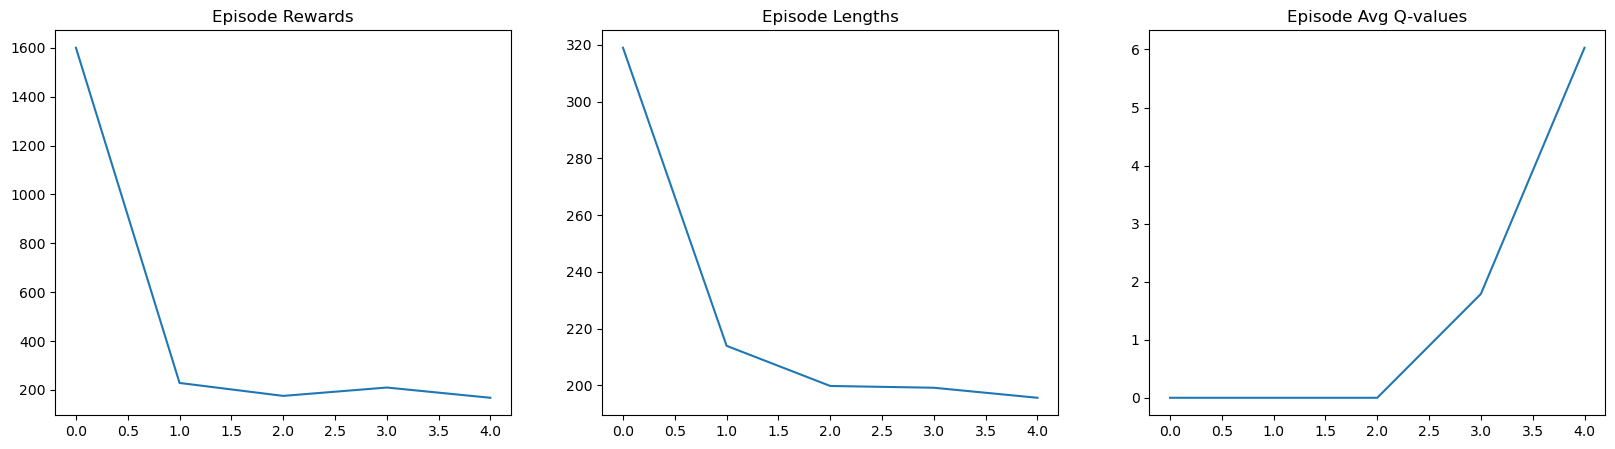

Average Reward over 0 episodes: nan
Evaluation reward: nan


/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [6]:
from env import COMPLEX_MOVEMENT, SIMPLE_MOVEMENT

# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
ACTION_SET = COMPLEX_MOVEMENT
EPISODES = 100
TMAX = 500
DISCOUNT_RATE = 0.9

# Moderate exploration
NOISE_DECAY = 0.995
NOISE = 0.1

NETWORK_TYPE = "duelling"
DDQN = True
PRIORITY = True

SAVE_DIR = f"./results/v2-{EPISODES}-episodes-{TMAX}-steps-{NETWORK_TYPE}-{'ddqn' if DDQN else 'dqn'}-{'priority' if PRIORITY else 'uniform'}-COMPLEX_MOVEMENT"

# Train the agent
mario, logger = train(
    ENV_ID,
    EPISODES,
    SAVE_DIR,
    action_set=ACTION_SET,
    network_type=NETWORK_TYPE,
    ddqn=DDQN,
    priority=PRIORITY,
    discount_rate=DISCOUNT_RATE,
    tmax=TMAX,
    initial_noise=NOISE,
    noise_decay=NOISE_DECAY,
    use_cuda=True,
)

# Plot training results
plot_training_results(logger)

A.L.E: Arcade Learning Environment (version 0.8.1+53f58b7)
[Powered by Stella]
/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Episode 0 - Step 247 - Epsilon 0.300 - Mean Reward 0.000 - Mean Length 247.000 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 1.504 - Time 2024-08-12T17:27:26
Model saved at results/v2-100-episodes-500-steps-duelling-ddqn-priority-COMPLEX_MOVEMENT-0.995-discount-0.3-noise-0.99-decay/model_logs/mario_model_0.chkpt
Episode 20 - Step 5253 - Epsilon 0.245 - Mean Reward 228.571 - Mean Length 250.143 - Mean Loss 0.000 - Mean Q Value 0.000 - Time Delta 10.438 - Time 2024-08-12T17:27:37


/home/tianyhe/Documents/mario-rl/src/agent/mario.py:180: UserWarning: Using a target size (torch.Size([32, 32])) that is different to the input size (torch.Size([32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = self.loss_fn(td_estimate, td_target)


Episode 40 - Step 10963 - Epsilon 0.201 - Mean Reward 156.098 - Mean Length 267.390 - Mean Loss 45.494 - Mean Q Value 0.039 - Time Delta 14.949 - Time 2024-08-12T17:27:52
Episode 60 - Step 16940 - Epsilon 0.164 - Mean Reward 131.148 - Mean Length 277.705 - Mean Loss 3435.784 - Mean Q Value 4.293 - Time Delta 37.562 - Time 2024-08-12T17:28:29
Episode 80 - Step 22513 - Epsilon 0.134 - Mean Reward 217.284 - Mean Length 277.938 - Mean Loss 5560.077 - Mean Q Value 7.038 - Time Delta 34.933 - Time 2024-08-12T17:29:04
MarioNet saved to ../model/dueling_ddqn_epo100_noise0.3_decay0.99_tau0.005_20240812_172935.pth at step 26848
Model saved as ../model/dueling_ddqn_epo100_noise0.3_decay0.99_tau0.005_20240812_172935.pth


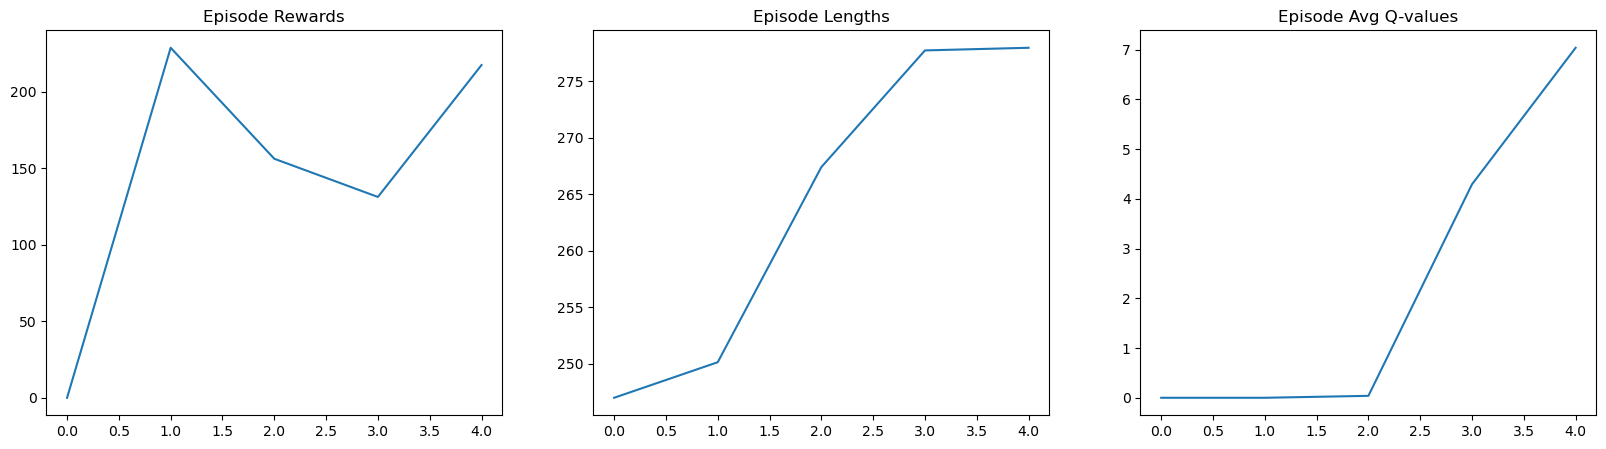

In [2]:
from env import SIMPLE_MOVEMENT, COMPLEX_MOVEMENT

# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
ACTION_SET = SIMPLE_MOVEMENT
FULL_ACTION_SPACE = False
EPISODES = 100
TMAX = 500
DISCOUNT_RATE = 0.7

# Aggressive exploration
NOISE_DECAY = 0.99
NOISE = 0.1

NETWORK_TYPE = "duelling"
DDQN = True
PRIORITY = True

SAVE_DIR = f"./results/v2-{EPISODES}-episodes-{TMAX}-steps-{NETWORK_TYPE}-{'ddqn' if DDQN else 'dqn'}-{'priority' if PRIORITY else 'uniform'}-COMPLEX_MOVEMENT-{DISCOUNT_RATE}-discount-{NOISE}-noise-{NOISE_DECAY}-decay"

# Train the agent
mario, logger = train(
    ENV_ID,
    EPISODES,
    SAVE_DIR,
    action_set=ACTION_SET,
    full_action_space=FULL_ACTION_SPACE,
    network_type=NETWORK_TYPE,
    ddqn=DDQN,
    priority=PRIORITY,
    discount_rate=DISCOUNT_RATE,
    tmax=TMAX,
    initial_noise=NOISE,
    noise_decay=NOISE_DECAY,
    use_cuda=True,
)

# Plot training results
plot_training_results(logger)

# Evaluate the agent
average_reward = evaluate(ENV_ID, mario, episodes=5, tmax=100, action_set=ACTION_SET, full_action_space=FULL_ACTION_SPACE, visualize=True)
print(f"Average reward over 5 episodes: {average_reward}")

## Training results from the old version

### Duelling DDQN with Prioritized Experience Replay (Simple Action Space)

The agent uses two neural networks: the online network and the target network. The online network is updated every step, while the target network is updated every 1000 steps. 

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 2000
SAVE_DIR = "./results/2000-episodes-1000-steps-duelling-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="duelling",
    ddqn=True,
    priority=True,
    initial_noise=1.0,
    noise_decay=0.995,
    tmax=1000
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True) # episodes=0 means run forever
print(f"Evaluation reward: {eval_reward}")


In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
ACTION_SET = COMPLEX_MOVEMENT
EPISODES = 5000
TMAX = 500
NETWORK_TYPE = "duelling"
DDQN = True
PRIORITY = True
SAVE_DIR = f"./results/{EPISODES}-episodes-{TMAX}-steps-{NETWORK_TYPE}-{'ddqn' if DDQN else 'dqn'}-{'priority' if PRIORITY else 'uniform'}-{ACTION_SET}"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=ACTION_SET,
    network_type=NETWORK_TYPE,
    ddqn=DDQN,
    priority=PRIORITY,
    initial_noise=1.0,
    noise_decay=0.999,
    tmax=TMAX
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True) # episodes=0 means run forever
print(f"Evaluation reward: {eval_reward}")

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-duelling-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="duelling",
    ddqn=True,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Dueling DDQN with Prioritized Experience Replay (Complex Actions Space)

In [ ]:
from env import COMPLEX_MOVEMENT

# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/complex-1000-episodes-duelling-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=COMPLEX_MOVEMENT,
    network_type="duelling",
    ddqn=True,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Traditional DDQN with Prioritized Experience Replay (Simple Action Space)

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-dqn-ddqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="DQN",
    ddqn=True,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Dueling DQN with Prioritized Experience Replay (Simple Action Space)

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-duelling-dqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="duelling",
    ddqn=False,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

### Traditional DQN with Prioritized Experience Replay (Simple Action Space)

In [ ]:
# Define training parameters
ENV_ID = "ALE/MarioBros-v5"
EPISODES = 1000
SAVE_DIR = "./results/simple-1000-episodes-dqn-dqn-priority"

# Train the agent
mario, logger = train(
    env_id=ENV_ID,
    episodes=EPISODES,
    save_dir=SAVE_DIR,
    action_set=SIMPLE_MOVEMENT,
    network_type="dqn",
    ddqn=False,
    priority=True,
    initial_noise=0.05,
    noise_decay=0.99
)

# Plot the training results
plot_training_results(logger)

# Evaluate the trained agent and capture gameplay frames
eval_reward, gameplay_frames = evaluate(ENV_ID, mario, episodes=0, action_set=SIMPLE_MOVEMENT, capture_frames=True)
print(f"Evaluation reward: {eval_reward}")

## Let's Play!

### Function to load and visualize the trained agent's gameplay

In [1]:
"""
Visualize the trained agent's gameplay
"""

import sys
from pathlib import Path

src_path = Path.cwd().parent / "src"
if src_path not in sys.path:
    sys.path.append(str(src_path))


import torch
import numpy as np
from agent import Mario
from env import create_env, SIMPLE_MOVEMENT
import matplotlib.pyplot as plt
from IPython.display import clear_output
from gym.spaces import Discrete

def load_and_visualize_gameplay(model_path, env_id, episodes=1, tmax=500, action_set=None):
    # Load the saved model
    checkpoint = torch.load(model_path)
    state_dim = checkpoint['state_dim']
    action_dim = checkpoint['action_dim']
    
    # Create a new Mario instance and load the saved state
    mario = Mario(state_dim, action_dim, save_dir=".")
    mario.load(model_path)
    mario.net.eval()  # Set the network to evaluation mode
    
    # Determine the action space and create the environment
    if action_set is None:
        # Use the full action space if not specified
        env = create_env(env_id, full_action_space=True) 
    else:
        # Use the specified action set
        env = create_env(env_id, action_set=action_set)

    # Get full action meanings
    full_action_meanings = env.unwrapped.get_action_meanings()

    def process_state(state):
        if isinstance(state, tuple):
            state = state[0]  # Take the first element if it's a tuple
        if isinstance(state, dict):
            state = state['rgb']  # Assuming the image is under the 'rgb' key
        return np.array(state)

    # Create a figure with larger size for better visibility
    plt.figure(figsize=(15, 10))

    # Keep track of Q-values over time
    q_values_history = []

    for episode in range(episodes):
        state = env.reset()
        state = process_state(state)
        total_reward = 0
        
        for t in range(tmax):
            # Get Q-values for all actions the model was trained on
            state_tensor = torch.FloatTensor(state).unsqueeze(0).to(mario.device)
            q_values = mario.net(state_tensor).squeeze().detach().cpu().numpy()
            q_values_history.append(q_values)
            
            # Choose action with highest Q-value from the model's action space
            model_action = mario.act(state, eps=0.05)
            
            # Map the model's action to the current action space
            env_action = model_action % env.action_space.n
            action_meaning = full_action_meanings[env_action]
            
            # Take the action
            next_state, reward, done, truncated, info = env.step(env_action)
            next_state = process_state(next_state)
            total_reward += reward

            # Render the game state
            frame = env.render()
            
            # Display the frame, action, and Q-values
            plt.clf()
            plt.subplot(211)
            plt.imshow(frame)
            plt.title(f"Episode {episode + 1}, Step {t + 1}, Total Reward: {total_reward}", pad=20)
            plt.axis('off')
            
            plt.subplot(212)
            bars = plt.bar(range(action_dim), q_values, alpha=0.5)
            plt.plot(range(action_dim), q_values, 'ro-')  # Add line plot for better visibility
            plt.title(f"Q-values (Chosen action: {action_meaning} [{env_action}])", pad=50)
            plt.xlabel("Model's Action Space")
            plt.ylabel("Q-value")
            plt.ylim(min(0, np.min(q_values) - 0.1), np.max(q_values) + 0.1)  # Dynamic y-axis

            # Add text annotations for Q-values and action meanings
            for i, bar in enumerate(bars):
                height = bar.get_height()
                action_meaning = full_action_meanings[i % env.action_space.n]  # Get the action meaning
                plt.text(bar.get_x() + bar.get_width()/2., height,
                         f'{q_values[i]:.2f}\n{action_meaning}',
                         ha='center', va='bottom', rotation=45, fontsize=8)

            plt.tight_layout()
            clear_output(wait=True)
            plt.show()

            state = next_state
            
            if done or truncated:
                break

        print(f"Episode {episode + 1} finished with total reward: {total_reward}")

    env.close()

    # Plot Q-values over time after the episode
    plt.figure(figsize=(15, 8))
    plt.title("Q-values over time", pad=20)
    for i in range(action_dim):
        action_meaning = full_action_meanings[i % env.action_space.n]
        plt.plot([q[i] for q in q_values_history], label=f"{action_meaning}")
    plt.xlabel("Time step")
    plt.ylabel("Q-value")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

/home/tianyhe/miniconda3/envs/mario-rl/lib/python3.11/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: 'libc10_cuda.so: cannot open shared object file: No such file or directory'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


### Load the Agent to Play

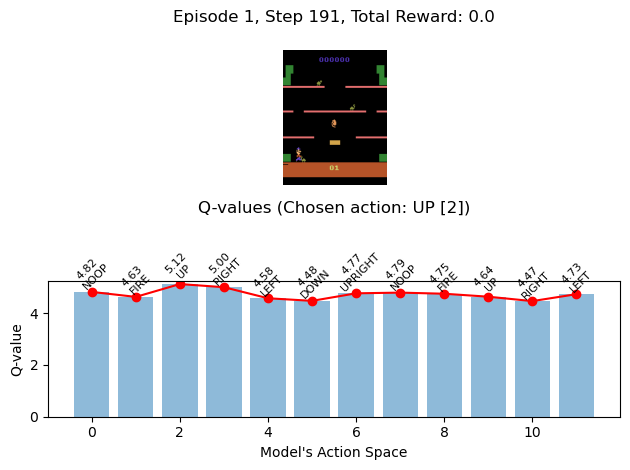

Episode 1 finished with total reward: 0.0


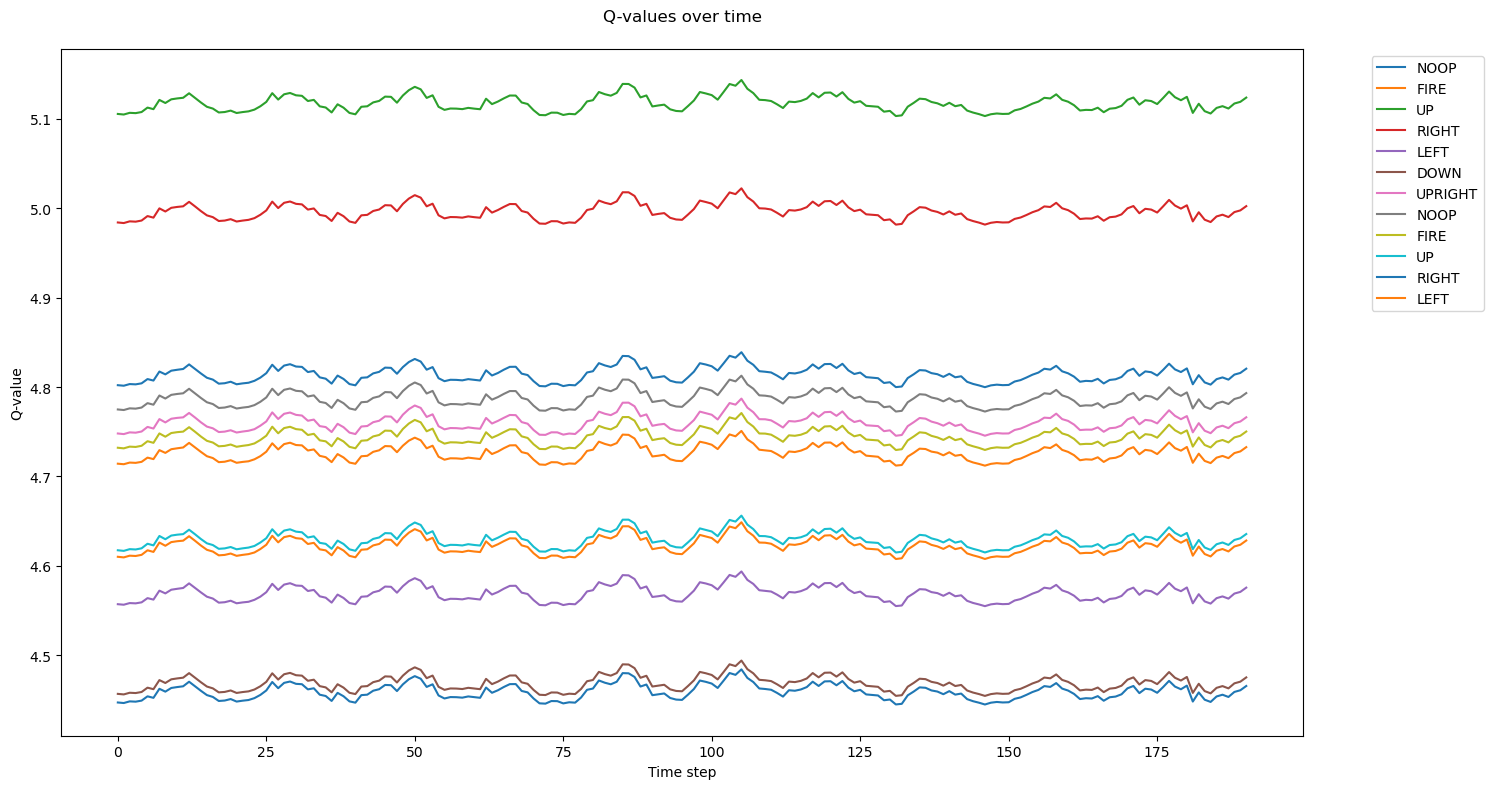

In [2]:
from env import SIMPLE_MOVEMENT

MODEL_PATH = f"../model/dueling_ddqn_epo500_noise0.05_decay0.99_20240811_183256.pth"

ENV_ID = "ALE/MarioBros-v5" # Environment ID
EPISODES = 1 # Number of episodes to visualize
TMAX = 500 # Maximum number of steps per episode
ACTION_SET = SIMPLE_MOVEMENT # Use the full action set

# Load the saved model and visualize gameplay
load_and_visualize_gameplay(MODEL_PATH, ENV_ID, episodes=EPISODES, tmax=TMAX, action_set=ACTION_SET)